In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

from entities_recognition.bilstm.train import trainIters, evaluate_all
from config import START_TAG, STOP_TAG

In [2]:
TRAIN_PATH = path.join(BASE_PATH, 'data/CoNLL-2003/eng.train')
print(TRAIN_PATH)

/Users/2359media/Documents/botbot-nlp/data/CoNLL-2003/eng.train


In [3]:
import io
import string

def ident(x):
    return x

def read_conll_2003(filename):
    all_data = []

    current_txt = []
    current_tags = []
    tagset = []

    fin = io.open(filename, 'r', encoding='utf-8', newline='\n', errors='ignore')
    for line in fin:
        line = line.strip()
        if len(line) > 0: # skip blank lines
            tmp = line.split(' ')
            if tmp[0] != '-DOCSTART-':
                current_txt.append(tmp[0])
                current_tags.append(tmp[-1])
                tagset.append(tmp[-1])
        else:
            if len(current_txt) > 0:
                all_data.append((current_txt, ' '.join(current_tags)))
                current_txt = []
                current_tags = []
    fin.close()

    tagset = list(set(tagset))
    tag_to_ix = {tag: key for key, tag in enumerate(tagset)}
    tag_to_ix[START_TAG] = len(tagset)
    tag_to_ix[STOP_TAG] = len(tagset) + 1

    print(tag_to_ix)
    print('Loaded %s sentences' % len(all_data))
    
    return tag_to_ix, all_data

In [4]:
from entities_recognition.bilstm.predict import read_tags

tag_to_ix, training_data = read_conll_2003(TRAIN_PATH)
result = []
for sentence, tag_seq in training_data:
    assert len(sentence) == len(tag_seq.split(' '))
#     print(read_tags(tokens_in, tag_seq.split(' ')))

{'I-PER': 0, 'I-LOC': 1, 'I-MISC': 2, 'B-MISC': 3, 'B-LOC': 4, 'B-ORG': 5, 'I-ORG': 6, 'O': 7, '<START>': 8, '<STOP>': 9}
Loaded 14041 sentences


Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
95m 17s (- 857m 36s) (1 10%) 33474.7969
156m 1s (- 624m 7s) (2 20%) 24021.9043
219m 31s (- 512m 14s) (3 30%) 20587.1953
283m 15s (- 424m 53s) (4 40%) 19324.5508
351m 22s (- 351m 22s) (5 50%) 17675.1484
476m 11s (- 317m 27s) (6 60%) 17375.0039
540m 43s (- 231m 44s) (7 70%) 15829.7979
606m 20s (- 151m 35s) (8 80%) 14996.5830
737m 17s (- 81m 55s) (9 90%) 14230.5713
798m 39s (- 0m 0s) (10 100%) 13026.6240


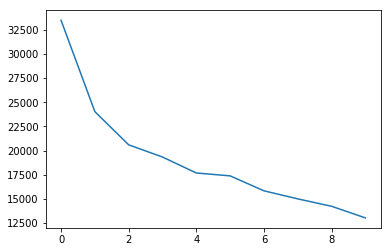

In [5]:
losses, model = trainIters(training_data, 
                           tag_to_ix,
                           learning_rate=1e-3,
                           n_iters=10, 
                           log_every=1,
                           tokenizer=ident,
                           verbose=1)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
fig, ax = plt.subplots()
plt.plot(losses)

In [6]:
import torch
model.eval()
torch.save(model.state_dict(), 'bilstm-rnn-conll2003-vanilla.bin')

Model recall

In [7]:
evaluate_all(model, training_data, tag_to_ix, tokenizer=ident)

0.9699048722872395

In [8]:
TEST_PATH_A = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testa')
TEST_PATH_B = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testb')
_, testing_data_a = read_conll_2003(TEST_PATH_A)
_, testing_data_b = read_conll_2003(TEST_PATH_B)

{'I-LOC': 0, 'I-PER': 1, 'I-MISC': 2, 'B-MISC': 3, 'I-ORG': 4, 'O': 5, '<START>': 6, '<STOP>': 7}
Loaded 3250 sentences
{'I-LOC': 0, 'I-PER': 1, 'I-MISC': 2, 'B-MISC': 3, 'B-LOC': 4, 'B-ORG': 5, 'I-ORG': 6, 'O': 7, '<START>': 8, '<STOP>': 9}
Loaded 3453 sentences


Accuracy on test sets

In [9]:
evaluate_all(model, testing_data_a, tag_to_ix, tokenizer=ident)

0.9652272107783965

In [10]:
evaluate_all(model, testing_data_b, tag_to_ix, tokenizer=ident)

0.9511790675137288

In [11]:
from entities_recognition.bilstm.predict import predict
from common.utils import wordpunct_tokenize

test_data = [
    'I live in Ho Chi Minh City, nice place, though my hometown is in Hanoi. I do miss it sometimes',
    'Trump’s role in midterm elections roils Republicans',
    'Kenya bans film about 2 girls in love because it’s ‘too hopeful’',
    'G.O.P. leaders and White House aides are trying to prepare President Trump for trouble in House and Senate races.'
]
predict(model, test_data, tag_to_ix, tokenizer=wordpunct_tokenize, delimiter=' ')

Raw predicted tags:
[7, 7, 7, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 2]
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 2, 2, 2, 7, 7, 7, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 6, 7, 7]


[{'PER': ['Ho Chi Minh City', 'Hanoi']},
 {'MISC': ['Republicans']},
 {'ORG': ['Kenya']},
 {'LOC': ['White House', 'House'], 'MISC': ['O . P'], 'ORG': ['Senate']}]

In [12]:
import json
with open('tag_to_ix.json', 'w') as tagfile:
    json.dump(tag_to_ix, tagfile)

`./conlleval < testa.out.txt`
```
processed 51578 tokens with 5942 phrases; found: 5808 phrases; correct: 4627.
accuracy:  96.56%; precision:  79.67%; recall:  77.87%; FB1:  78.76
              LOC: precision:  90.47%; recall:  77.03%; FB1:  83.21  1564
             MISC: precision:  83.25%; recall:  73.86%; FB1:  78.28  818
              ORG: precision:  67.11%; recall:  64.50%; FB1:  65.78  1289
              PER: precision:  77.96%; recall:  90.45%; FB1:  83.74  2137
```
`./conlleval < testb.out.txt`
```
processed 46666 tokens with 5879 phrases; found: 5493 phrases; correct: 4102.
accuracy:  94.65%; precision:  74.68%; recall:  69.77%; FB1:  72.14
              LOC: precision:  89.33%; recall:  74.82%; FB1:  81.44  1397
             MISC: precision:  68.47%; recall:  68.66%; FB1:  68.56  704
              ORG: precision:  68.00%; recall:  60.39%; FB1:  63.97  1475
              PER: precision:  71.41%; recall:  84.66%; FB1:  77.48  1917
               X-: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
```